In [1]:
import skfem
import meshio
import numpy as np
import matplotlib.pyplot as plt
import h5py

import pandas as pd
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace, mass
from skfem.helpers import grad, dot, laplacian

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh, eigs, splu, LinearOperator

import scipy.linalg


In [20]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True, cmap='viridis')
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True, cmap='viridis')
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True, cmap='viridis')
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True, colormap='viridis', cmap='viridis')
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')
    plt.tight_layout()
    plt.show()

    # Campo vectorial de velocidad (quiver)
    # Para P2, necesitamos solo los valores en los vértices (primeros n_nodes)
    n_vertices = mesh.p.shape[1]
    
    # Extraer solo los valores en los vértices
    u_x_vertices = u_x[:n_vertices]
    u_y_vertices = u_y[:n_vertices]
    u_mag_vertices = np.sqrt(u_x_vertices**2 + u_y_vertices**2)
    
    # Obtener coordenadas de los nodos
    coords = mesh.p
    x_coords = coords[0, :]
    y_coords = coords[1, :]
    
    
    # Create a new figure for the quiver plot
    fig_quiver, ax_quiver = plt.subplots(1, 1, figsize=(10, 8))
    
    # Quiver plot
    quiver = ax_quiver.quiver(x_coords, y_coords, 
                      u_x_vertices, u_y_vertices, u_mag_vertices,
                      cmap='jet', scale=20, alpha=1, width=0.005)
    
    # Plot domain boundaries
    nodes  = mesh.p
    facets = mesh.facets
    boundary_facets = mesh.boundary_facets()

    # Plot all boundary facets
    for i, e in enumerate(boundary_facets):
        facets_e = facets[:, e]
        nodosx = nodes[0, facets_e]
        nodosy = nodes[1, facets_e]
        ax_quiver.plot(nodosx, nodosy, 'k-', linewidth=1.5, alpha=0.8)
    
    
    ax_quiver.set_title(r'Campo de velocidad $\mathbf{u}$')
    ax_quiver.set_aspect('equal')
    ax_quiver.set_xlabel('x')
    ax_quiver.set_ylabel('y')
    
    # Add colorbar
    cbar = plt.colorbar(quiver, ax=ax_quiver)
    cbar.set_label('Magnitud de velocidad')

    plt.tight_layout()
    plt.show()

### Dominio U refinado

In [3]:
f = h5py.File('umesh_h3.h5', 'r')
print(list(f.keys()))

['boundaries', 'mesh']


In [4]:
coordinates_mesh = f['mesh/coordinates'][:]
elements_mesh    = f['mesh/topology'][:]

coordinates_boundaries = f['/boundaries/coordinates'][:]
elements_boundaries    = f['/boundaries/topology'][:]
values_boundaries      = f['/boundaries/values'][:]

In [5]:
boundary_wall = np.where(f['/boundaries/values'][:] == 1)[0]
boundary_elements_wall = elements_boundaries[boundary_wall]

boundary_inflow = np.where(f['/boundaries/values'][:] == 2)[0]
boundary_elements_inflow = elements_boundaries[boundary_inflow]

boundary_outflow = np.where(f['/boundaries/values'][:] == 3)[0]
boundary_elements_outflow = elements_boundaries[boundary_outflow]

In [6]:
malla_refinado = skfem.MeshTri(coordinates_mesh.T, elements_mesh.T)

Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


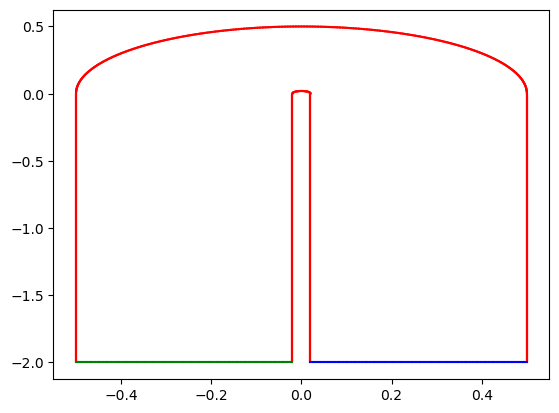

In [7]:
for i in boundary_elements_wall:
    v0 = coordinates_mesh[i[0]]
    v1 = coordinates_mesh[i[1]]
    plt.plot([v0[0], v1[0]], [v0[1], v1[1]], color='r')

for i in boundary_elements_inflow:
    v0 = coordinates_mesh[i[0]]
    v1 = coordinates_mesh[i[1]]
    plt.plot([v0[0], v1[0]], [v0[1], v1[1]], color='g')

for i in boundary_elements_outflow:
    v0 = coordinates_mesh[i[0]]
    v1 = coordinates_mesh[i[1]]
    plt.plot([v0[0], v1[0]], [v0[1], v1[1]], color='b')



In [9]:
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(malla_refinado, element['u'], intorder=4),
    'p': Basis(malla_refinado, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N      = Nu + Np

In [10]:
mu    = 0.035 # viscosidad dinámica
rho   = 1.0   # densidad
nu    = mu / rho # Viscosidad cinemática
V_car = 1.0    # Velocidad característica
L_car = 1.0    # Longitud característica
Re    = V_car * L_car / nu


In [11]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)
# Término convectivo linealizado
@BilinearForm
def convection(u, v, w):
    advection_field = w['w']
    grad_u = grad(u)
    return np.einsum('j...,ij...,i...->...', advection_field, grad_u, v)

# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   

F_u = basis['u'].zeros()
F_p = basis['p'].zeros()
F = np.hstack([F_u, F_p])

In [16]:
def u_out_y(x, y):
    return  -(x-0.02)*(0.5-x) + y*0.0

dofs_entrada  = basis_u.get_dofs(boundary_inflow).all()
dofs_p_salida = basis_p.get_dofs(boundary_outflow).all()

xin   = basis_u.doflocs[0, dofs_entrada[::2]]
yin   = basis_u.doflocs[1, dofs_entrada[1::2]]

def u_in_y(x, y):
    return  (x-xin[1])*(xin[0]-x) + y*0.0

x_boundaries = np.zeros(Nu+Np)
x_boundaries[dofs_entrada[::2]]  = 0.0
x_boundaries[dofs_entrada[1::2]] = u_in_y(xin, yin)/np.max(u_in_y(xin, yin))

x_boundaries[Nu + dofs_p_salida[0]] = 0.0

D_all = np.concatenate([
    basis_u.get_dofs(boundary_wall).all(),
    basis_u.get_dofs(boundary_inflow).all(),
    Nu+np.array([dofs_p_salida[0]])
]) 

In [18]:
# Calcular solución inicial de stokes
K_stokes = bmat([[mu * A,     B.T],  
                 [B,         None]], format='csr')

sol0 = solve(*condense(K_stokes, F, D=D_all, x=x_boundaries))
u_ref = sol0[:Nu].copy()
p_ref = sol0[Nu:Nu+Np].copy()

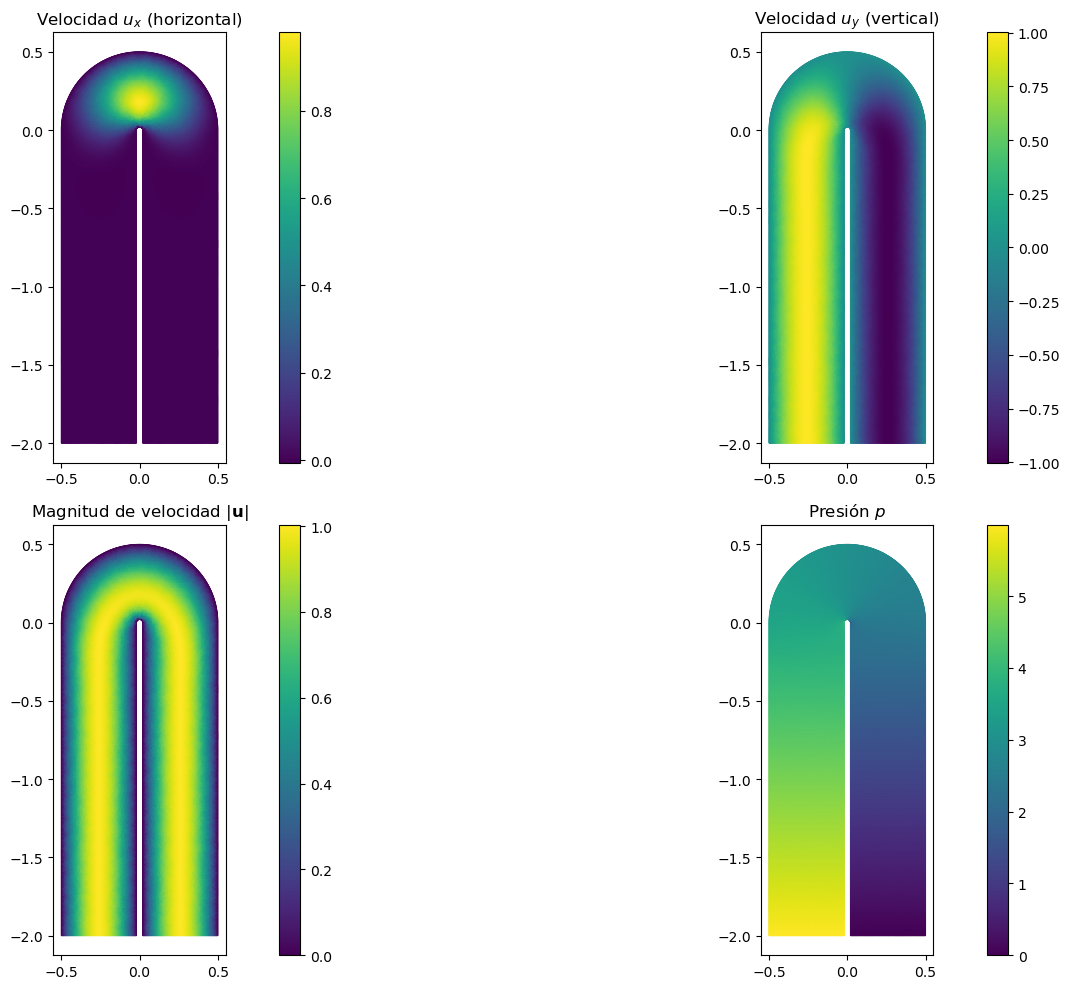

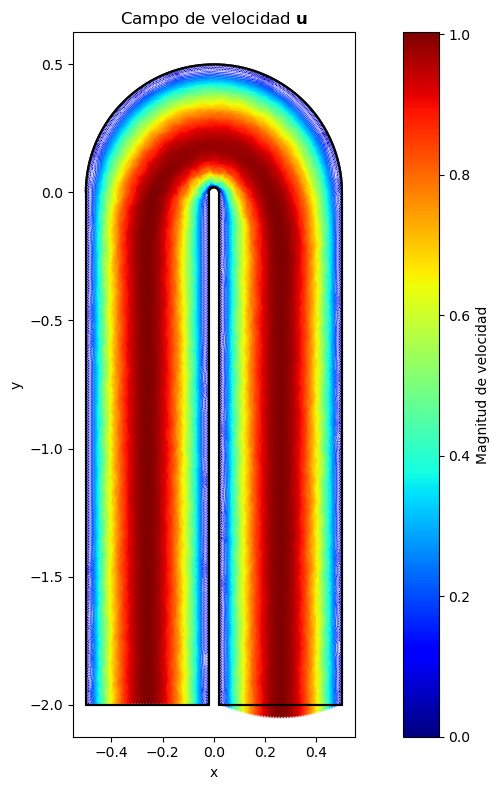

In [19]:
graficar_stokes(u_ref, p_ref, malla_refinado, basis_p, basis_u)

### Malla arteria

In [76]:
f = h5py.File('Carotid_h1.h5', 'r')
print(list(f.keys()))

['boundaries', 'mesh']


In [77]:
coordinates_mesh = f['mesh/coordinates'][:]
elements_mesh    = f['mesh/topology'][:]

coordinates_boundaries = f['/boundaries/coordinates'][:]
elements_boundaries    = f['/boundaries/topology'][:]
values_boundaries      = f['/boundaries/values'][:]

In [78]:
boundary_1 = np.where(f['/boundaries/values'][:] == 1)[0]
boundary_elements_1 = elements_boundaries[boundary_1]

boundary_2 = np.where(f['/boundaries/values'][:] == 2)[0]
boundary_elements_2 = elements_boundaries[boundary_2]

boundary_3 = np.where(f['/boundaries/values'][:] == 3)[0]
boundary_elements_3 = elements_boundaries[boundary_3]

boundary_4 = np.where(f['/boundaries/values'][:] == 4)[0]
boundary_elements_4 = elements_boundaries[boundary_4]

boundary_5 = np.where(f['/boundaries/values'][:] == 5)[0]
boundary_elements_5 = elements_boundaries[boundary_5]

boundary_6 = np.where(f['/boundaries/values'][:] == 6)[0]
boundary_elements_6 = elements_boundaries[boundary_6]

boundary_7 = np.where(f['/boundaries/values'][:] == 7)[0]
boundary_elements_7 = elements_boundaries[boundary_7]

boundaries = [boundary_elements_1, boundary_elements_2,
             boundary_elements_3, boundary_elements_4,
              boundary_elements_5, boundary_elements_6,
              boundary_elements_7]

boundary_wall = boundary_1
boundary_inflow = boundary_2
boundary_outflow = np.concatenate([boundary_3, boundary_4, boundary_5, boundary_6, boundary_7])

In [79]:
diccionario_skfem = {
    'p': coordinates_mesh,
    't': elements_mesh,
    'subdomains': None,
    'boundaries': {'Wall': boundary_wall,
                   'Inflow': boundary_inflow,
                   'Outflow': boundary_outflow
                  }
}

In [80]:
malla_arteria = skfem.MeshTri(coordinates_mesh.T, elements_mesh.T)

Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


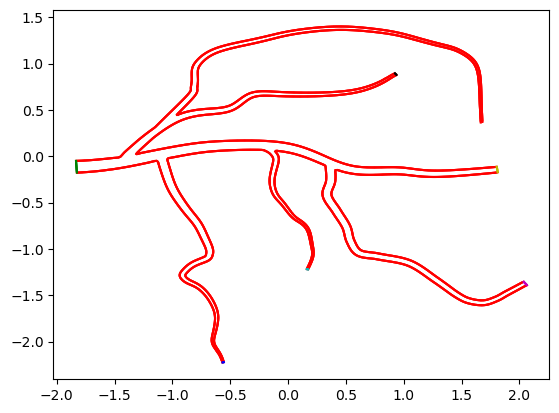

In [81]:
colores = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for j, color in zip(boundaries, colores):
    for i in j:
        v0 = coordinates_mesh[i[0]]
        v1 = coordinates_mesh[i[1]]
        plt.plot([v0[0], v1[0]], [v0[1], v1[1]], color=color)


In [82]:
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(malla_arteria, element['u'], intorder=4),
    'p': Basis(malla_arteria, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N      = Nu + Np

In [83]:
mu    = 0.035 # viscosidad dinámica
rho   = 1.0   # densidad
nu    = mu / rho # Viscosidad cinemática
V_car = 1.0    # Velocidad característica
L_car = 1.0    # Longitud característica
Re    = V_car * L_car / nu


In [84]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)
# Término convectivo linealizado
@BilinearForm
def convection(u, v, w):
    advection_field = w['w']
    grad_u = grad(u)
    return np.einsum('j...,ij...,i...->...', advection_field, grad_u, v)

# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   

F_u = basis['u'].zeros()
F_p = basis['p'].zeros()
F = np.hstack([F_u, F_p])

In [105]:
u_in_y(xin, yin)/np.max(u_in_y(xin, yin))

array([-0.        , -0.        ,  0.02448858,  0.19181957,  0.66105968,
        0.51760767,  0.39157058,  0.28298466,  0.11793428,  0.06108972,
        1.        ,  0.8218634 ,  0.02135037, -0.00289476,  0.008079  ,
        0.0091264 ,  0.23522064,  0.15268389,  0.58715393,  0.73928401,
        0.45240853,  0.3350973 ,  0.08727219,  0.03885599,  0.90875621])

In [106]:
print(xin)
print(yin)

[-1.82744622 -1.8267535  -1.82602668 -1.8298912  -1.83224404 -1.83165622
 -1.83106828 -1.83047974 -1.82930255 -1.82870841 -1.83341897 -1.83283162
 -1.82809544 -1.82709986 -1.82777083 -1.82639009 -1.83018547 -1.82959688
 -1.83195013 -1.83253783 -1.83136225 -1.83077401 -1.82900548 -1.82840192
 -1.83312529]
[-0.1528762  -0.16459587 -0.17675886 -0.11067662 -0.06999005 -0.08015985
 -0.09033164 -0.10050279 -0.12087738 -0.13118634 -0.04966555 -0.05982543
 -0.14177737 -0.15873604 -0.14732678 -0.17067736 -0.1055897  -0.115777
 -0.07507495 -0.06490774 -0.08524575 -0.09541722 -0.12603186 -0.13648185
 -0.05474549]


In [112]:
dofs_entrada  = basis_u.get_dofs(boundary_inflow).all()
dofs_p_salida = basis_p.get_dofs(boundary_outflow).all()

xin   = basis_u.doflocs[0, dofs_entrada[::2]]
yin   = basis_u.doflocs[1, dofs_entrada[1::2]]

def u_in_y(x, y):
    return  (y-np.max(yin))*(np.min(yin)-y) + x*0.0

x_boundaries = np.zeros(Nu+Np)
x_boundaries[dofs_entrada[::2]]  = u_in_y(xin, yin)/np.max(u_in_y(xin, yin))
x_boundaries[dofs_entrada[1::2]] = 0.0

x_boundaries[Nu + dofs_p_salida[0]] = 0.0

D_all = np.concatenate([
    basis_u.get_dofs(boundary_wall).all(),
    basis_u.get_dofs(boundary_inflow).all(),
    Nu+np.array([dofs_p_salida[0]])
]) 

In [113]:
# Calcular solución inicial de stokes
K_stokes = bmat([[mu * A,     B.T],  
                 [B,         None]], format='csr')

sol0 = solve(*condense(K_stokes, F, D=D_all, x=x_boundaries))
u_ref = sol0[:Nu].copy()
p_ref = sol0[Nu:Nu+Np].copy()

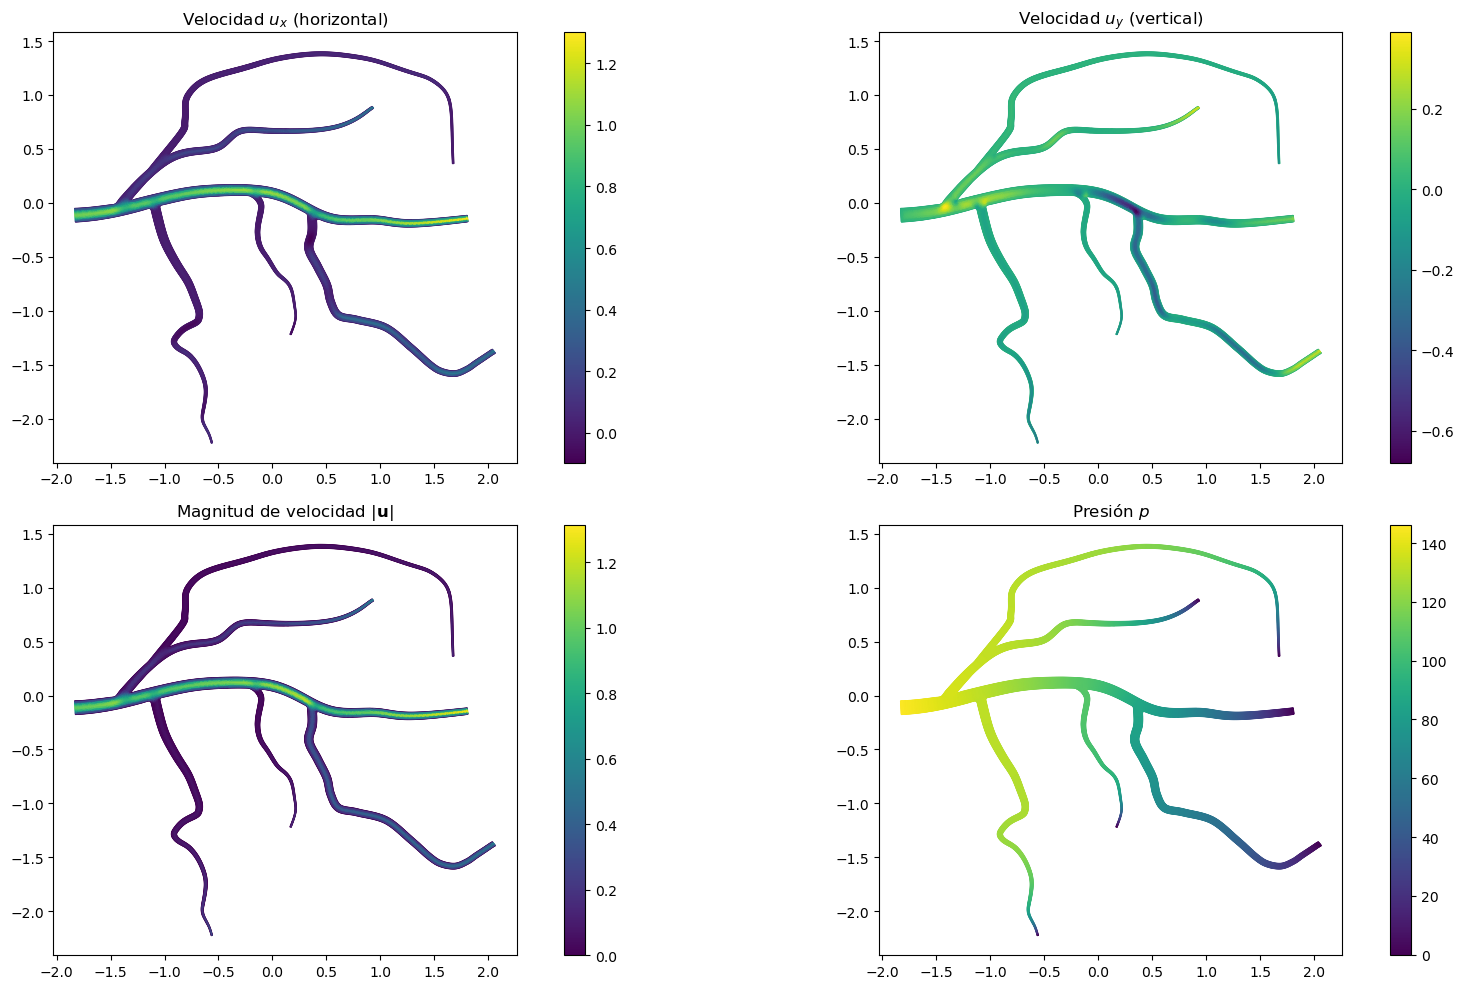

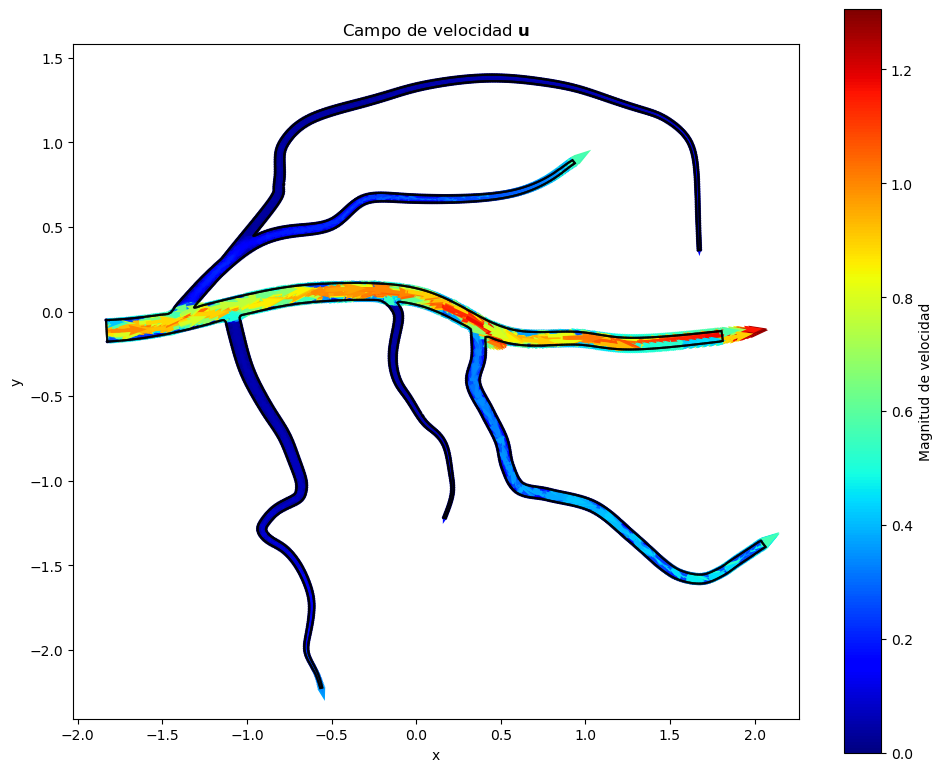

In [114]:
graficar_stokes(u_ref, p_ref, malla_arteria, basis_p, basis_u)

In [115]:
Nu = basis_u.N

# Visualización
fig = plt.figure(figsize=(16, 12), dpi=600)

# Separar componentes de velocidad
# Para ElementVector, los DOFs están organizados por componente
n_nodes = Nu // 2
u_x = u_ref[0::2]  # componente x
u_y = u_ref[1::2]  # componente y

# Magnitud de velocidad
u_magnitude = np.sqrt(u_x**2 + u_y**2)

# Crear bases escalares para visualizar cada componente
basis_scalar = Basis(malla_arteria, ElementTriP2(), intorder=4)

ax = fig.add_subplot(1, 1, 1)
basis_scalar.plot(u_magnitude, ax=ax, shading='gouraud', colorbar=True, cmap='viridis')
ax.set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

# # Componente u de la velocidad
# basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True, cmap='viridis')
# axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
# axes[0, 0].set_aspect('equal')

# # Componente v de la velocidad
# basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True, cmap='viridis')
# axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
# axes[0, 1].set_aspect('equal')

# Magnitud de velocidad

# plt.gca().set_aspect('equal')

# # Presión
# basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True, colormap='viridis', cmap='viridis')
# axes[1, 1].set_title(r'Presión $p$')
# axes[1, 1].set_aspect('equal')
# plt.tight_layout()
# plt.show()